In [1]:
# import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib

# for fuzzy matching variable names for various NOAA data sets
from fuzzywuzzy import fuzz
import re 

# To view dictionaries in a nicer format!
import pprint

# For datetime
from datetime import datetime

# To calculate ECDF
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline 

# libraries for geographic visualization 
# import OSMPythonTools as osm
# from mpl_toolkits.basemap import Basemap
# _geoslib module missing for the mpl_toolkits.basemap import

# Cite when you use cartopy 
import cartopy 

In [2]:
from IPython.display import display

pd.options.display.max_columns = None

In [3]:
print(os.getcwd())

C:\Users\wlang\Documents\UW files\Research\Great Lakes Data


# NOAA Data

First, we will read in and clean NOAA data for the western basin of Lake Erie.

## Concatenate Data Sets

In [ ]:
# Compare NOAA data sets - do all the different sets have the same format?
# First look at one station

WE02_2014 = pd.read_csv('NOAA Western Lake Erie\WE02\WE02_2014_annual_summary.csv', na_values='NAN', skiprows=[1, 2])
WE02_2015 = pd.read_csv('NOAA Western Lake Erie\WE02\WE02_2015_annual_summary.csv', na_values='NAN', skiprows=[1, 2])

In [ ]:
print(WE02_2014.shape, WE02_2015.shape)
# Different shapes

print('Intersection of variables: ', list(set(list(WE02_2014.columns)).intersection(list(WE02_2015.columns))))

print('Variables in 2014 not in 2015:')
print(np.setdiff1d(list(WE02_2014.columns), list(WE02_2015.columns)))

print('Variables in 2015 not in 2014:')
print(np.setdiff1d(list(WE02_2015.columns), list(WE02_2014.columns)))

It seems that the NOAA data sets don't have a set format/convention for variable naming nor do they have a uniform set of variables. I will stil combine the data sets for the sake of data visualization - it's easier to have all the data within one set. 

Some variable names vary due to small details such as capitalization ex. ph, pH. To (hopefully) merge these columns together when concatenating the data sets, I will set all column names to lowercase.

Moored buoy data sets have coordinates stated in a separate data set! I will add latitude and longitude to the moored buoys' data sets first.

In [4]:
## read in all data sets
# also add coordinate data to the buoy data! Format in terms of longitude, latitude
# Coordinate files for moored buoys should just be ONE set of coordinates 

# Function taken from stack overflow
def is_unique(coords):
    coords_np = coords.to_numpy() 
    return (coords_np[0] == coords_np).all()

# Check if there are multiple coordinates for moored buoys. If there are, check if the coordinates differ
def get_coords(coord_df):
    if coord_df.shape[0] == 1:
        return(coord_df)
    else:
        if is_unique(coord_df):
            coord_df = coord_df.iloc[[0],]
            return(coord_df)
        else: 
            raise Exception('There should only be one unique set of coordinates for moored buoys. There are {} sets of coordinates'.
                            format(coord_df.drop_duplicates().shape[0]))

In [5]:
noaa_folder = 'NOAA Western Lake Erie'
noaa_locs = ['WE02', 'WE04', 'WE08', 'WE13', 'Small_boat_2012_2018', 'Small_boat_2019']

# Dictionary to store lake data
NOAA_sets = {} 

# Dictionary to store lake coordinates
NOAA_coords = {}

# Dictionary to store measurement unit details and apparatuses
dataset_measure_details = {}

# Read in files 
for location in noaa_locs: 
    
    noaa_dir = os.path.join(os.getcwd(), noaa_folder, location)
    
    # Look through directory defined in noaa_dir
    for (root,dirs,files) in os.walk(noaa_dir, topdown=True): 
        
        for file in files:
            
            # Read in lake data, which are CSV files
            if file.endswith('.csv'):
                
                # Just for the data sets that begin with WE__
                if file.startswith('WE'):
                
                    # first the data
                    NOAA_sets[file[:-4]] = pd.read_csv(os.path.join(noaa_dir, file), engine='python', na_values=['NAN', 'NAN '], skiprows=[1, 2], parse_dates=True)

                    # store the additional header rows which are details on units and measurement apparatuses
                    dataset_measure_details[file[:-4]] =  pd.read_csv(os.path.join(noaa_dir, file), engine='python', na_values=['NAN', 'NAN '], nrows=2, parse_dates=True)

                    # Add column for station name in data dataframe
                    NOAA_sets[file[:-4]]['station'] = location

                    # Add column for station in dataset measure details 
                    dataset_measure_details[file[:-4]]['station'] = float('NaN')
                
                # For the rest of the files where there aren't additional header rows
                else:
                    
                    # Read in data
                    NOAA_sets[file[:-4]] = pd.read_csv(os.path.join(noaa_dir, file), engine='python', na_values='NAN', parse_dates=True)
                    
                    # Add column for station name
                    NOAA_sets[file[:-4]]['station'] = location
                    
            # Read in coordinate data 
            elif 'lonlat' in file:
                NOAA_coords[location] = get_coords(pd.read_fwf(
                    os.path.join(noaa_dir, file), delimiter=' ', header=None))
    

In [ ]:
# Get sum of dataframe lengths in dictionary 
print(sum([dataset.shape[0] for key, dataset in NOAA_sets.items()]))

print('---------------')

for key, dataset in NOAA_sets.items():
    print(dataset.shape[0])

In [ ]:
print(NOAA_coords.keys())
list(NOAA_sets.keys())

In [ ]:
print(NOAA_sets['WE02_2016_annual_summary'].shape)
print(dataset_measure_details['WE02_2016_annual_summary'].shape)

In [6]:
# lower case column names for all data sets to avoid issues in merging columns due to capitalization differences
# add coordinates of moored stations; boat stations have coordinates in data set already

for key, dataset in NOAA_sets.items():
    dataset.columns = dataset.columns.str.lower()
    
    # add column for longitude, latitude for the data sets that start with WE
    if key.startswith('WE'):
        
        # add units in column names
        dataset.columns = ['{} ({})'.format(ind.lower(), val) if isinstance(val, str) else 
                           ind.lower() for ind, val in dataset_measure_details[key].iloc[0,].iteritems()]
        
        ### Note that from here onwards, NOAA_coords has three additional columns compared to dataset_measure_details ###
        
        # Add coordinates 
        dataset['longitude (decimal deg)'] = float(NOAA_coords[key.split(sep='_')[0]][0]) # just get the WE__ portion of the name
        dataset['latitude (decimal deg)'] = float(NOAA_coords[key.split(sep='_')[0]][1])
        
        # Instantiate site variable in WE__ data sets as the station variable value to match with small boat data sets
        dataset['site'] = dataset['station'] ## this seems to cause problems!! Extra rows are aren't NaN
        
        # Save measurement units and measurement tools detail in dataset_measure_details
        # dataset_measure_details[key] = dataset.iloc[0:1,]
        
        # Drop the measurement units + tool rows from the WE__ data sets
        # dataset.drop([0, 1], inplace = True)

In [7]:
# Rename organic_dissolved_oxygen (milligrams per liter) column as organic_dissolved_oxygen_saturation_flags,
#   organic_dissolved_oxygen.1 (milligrams per liter) as organic_dissolved_oxygen (milligrams per liter)
#   in the 2015 annual summary data sets for WE04, WE08 and WE13

diss_oxy_fix_sets = ['WE04_2015_annual_summary', 'WE08_2015_annual_summary', 'WE13_2015_annual_summary']

for dat in diss_oxy_fix_sets:
    NOAA_sets[dat].rename(columns = { 
    'organic_dissolved_oxygen (milligrams per liter)': 'organic_dissolved_oxygen_saturation_flags', 
    'organic_dissolved_oxygen.1 (milligrams per liter)': 'organic_dissolved_oxygen (milligrams per liter)'}, 
                          inplace = True)

In [ ]:
print(NOAA_sets['WE02_2016_annual_summary'].shape)
print(dataset_measure_details['WE02_2016_annual_summary'].shape)

In [8]:
# Merge data sets - full outer join or save data frame values in a list to create a list of data frames
NOAA_full_dat = pd.concat(NOAA_sets.values(), ignore_index=True, sort=False)

## Data Cleaning

### Data Type Issues

There are some numeric variables that are object types; the reasons are listed below.

| Variable | Reason for Error | 
| --- | --- | 
| `organic_dissolved_oxygen (milligrams per liter)` | For 2015 annual summaries for WE04, WE08 and WE13, the observations are actually flag values| 
| `wind speed (knots)` | Contains random dates and string values; exclusive to small boat data sets |
| `CTD Tramission (%)` | Row 278798 is a string value 'nd' | 
| `CTD Dissolved Oxygen (mg/L)`| |
| `CTD Tramission (%)` | | 
| `CTD Dissolved Oxygen (mg/L)` | |
| `secchi depth (m)` | Observations contain non-numeric characters ie. '< ' | 
| | |

Still have some unresolved columns after looking at 2019

Numeric columns with < __ (grouped values)
secchi depth


In [ ]:
NOAA_full_dat.dtypes[NOAA_full_dat.dtypes == 'object']

#### Organic Dissolved Oxygen

In [ ]:
# Stations with flags in dissolved oxygen (milligrams per liter) instead of actual measurements 
print(NOAA_full_dat.loc[NOAA_full_dat['organic_dissolved_oxygen (milligrams per liter)'].str.contains(' ').notnull(), 'station'].unique())

dis_oxy_mislabel_flag_yr = NOAA_full_dat.loc[NOAA_full_dat['organic_dissolved_oxygen (milligrams per liter)'].str.contains(' ').notnull()] 

# Which year are the mislabelled organic dissolved oxygen (milligrams per liter) 
print(dis_oxy_mislabel_flag_yr['timestamp (UTC)'].str.split(pat = '[/ \\s]').map(lambda x: x[2]).unique())

The data sets that have flag values for `organic_dissolved_oxygen (milligrams per liter)` are the 2015 annual summaries for stations WE04, WE08 and WE13. Looking in depth at the column names for these data sets, the `organic_dissolved_oxygen_saturation_flags` column does not exist. It appears that for these data sets, the oxygen saturation flag column was mislabelled as organic dissolved oxygen. To resolve this issue, I renamed the `organic_dissolved_oxygen.1 (milligrams per liter)` column as `organic_dissolved_oxygen_saturation_flags` for the 2015 annual summary data sets for stations WE04, WE08 and WE13 (done above prior to the data set concatenation). 

In [ ]:
non_null_DO1 = NOAA_full_dat[NOAA_full_dat['organic_dissolved_oxygen.1 (milligrams per liter)'].notnull()].index.tolist()
print('Number of non-null rows for organic_dissolved_oxygen.1 (milligrams per liter):', len(non_null_DO1))
print('Number of null organic_dissolved_oxygen_saturation_flags rows where there are non-null organic_dissolved_oxygen.1 (milligrams per liter) rows:', sum(NOAA_full_dat.iloc[non_null_DO1]['organic_dissolved_oxygen_saturation_flags'].isnull()))

In [ ]:
# Check if organic_dissolved_oxygen (milligrams per liter) is the flag variable for organic_dissolved_oxygen.1 (milligrams per liter)

# Are the non-null rows for organic_dissolved_oxygen.1 (milligrams per liter) the same rows as where the mislabelled organic dissolved oxygen (milligrams per liter) are?
print('Check if non-null organic_dissolved_oxygen.1 rows == mislabelled organic dissolved oxygen (milligrams per liter) rows:', NOAA_full_dat.loc[NOAA_full_dat['organic_dissolved_oxygen.1 (milligrams per liter)'].notnull()].index.tolist() == dis_oxy_mislabel_flag_yr['organic_dissolved_oxygen (milligrams per liter)'].index.tolist())

In [ ]:
dis_oxy_mislabel_flag_yr['organic_dissolved_oxygen (milligrams per liter)'].index.tolist()

In [ ]:
nonnull_ctd_oxy = NOAA_full_dat.loc[NOAA_full_dat['ctd dissolved oxygen (mg/l)'].notnull(), 'ctd dissolved oxygen (mg/l)'] 
np.where(nonnull_ctd_oxy.str.replace(pat = '.', repl = '', regex = False).str.isnumeric() == False)
nonnull_ctd_oxy.index.tolist()[820]
nonnull_ctd_oxy[278551]

There is only one non-null row in `ctd dissolved oxygen (mg/l)` that is non-numeric (a space character), so I will cast this variable to numeric. 

In [11]:
NOAA_full_dat['ctd dissolved oxygen (mg/l)'] = pd.to_numeric(NOAA_full_dat['ctd dissolved oxygen (mg/l)'], errors = 'coerce')

#### CTD Transmission

Note variable has typo in name - `tramission` instead of `transmission`. For `ctd tramission (%)`, there is only one row that is non-numeric with value of `'nd'`. As a result, it is safe to cast `ctd tramission (%)` to numeric using `pd.numeric()` with `errors = 'coerce'`.

In [ ]:
# print(NOAA_full_dat.loc[NOAA_full_dat['CTD Tramission (%)'].str.contains('<').notnull(), 'station'])

print('ctd tramission (%) observations are only in:', NOAA_full_dat.loc[NOAA_full_dat['ctd tramission (%)'].notnull(), 'station'].unique())

# Only one observation in ctd tramission that is all alphabetical characters
print('Number of entirely alphabetical entries in ctd tramission (%):', NOAA_full_dat.loc[NOAA_full_dat['ctd tramission (%)'].notnull(), 'ctd tramission (%)'].str.isalpha().sum())

# Check if other rows besides row 278798 are string
NOAA_full_dat['ctd tramission (%)'][278799:].astype(float) 

In [12]:
# Cast ctd tramission (%) to numeric
NOAA_full_dat['ctd tramission (%)'] = pd.to_numeric(NOAA_full_dat['ctd tramission (%)'], errors = 'coerce')

#### Wind Speed

There are five rows that have dates and one that is a string. We can cast `wind speed (knots)` as a float using `pd.to_numeric()` with `errors = 'coerce'` since the non-numeric entries will be unused data. 

In [ ]:
print('wind speed (knots) observations are only in:', NOAA_full_dat.loc[NOAA_full_dat['wind speed (knots)'].notnull(), 'station'].unique())

In [ ]:
# NOAA_full_dat.loc[NOAA_full_dat['wind speed (knots)'].str.isnumeric() == False, 'wind speed (knots)']

NOAA_full_dat[NOAA_full_dat['wind speed (knots)'].str.contains('-') == True]

In [13]:
# Cast wind speed (knots) to float
NOAA_full_dat['wind speed (knots)'] = pd.to_numeric(NOAA_full_dat['wind speed (knots)'], errors = 'coerce')

In [ ]:
len(NOAA_full_dat.dtypes[NOAA_full_dat.dtypes == 'object'])

There are several columns, such as `water_temperature (degrees Celsius)` and `chlorophylla (RFU)`, that are read in as object types but are actually numeric. I will run through the dataframe to cast numeric columns read in as object to float using `pd.to_numeric()` with `errors = coerce`. The reasoning is that non-numeric values in a numeric column don't belong and so we will mark those values as `NaN`. The only object variables in the concatenated data set are the flag variables, `sample depth (category)`, `sky`, `station` and `site` so these variables will be ignored in the cast to float process.

**Update: don't cast variables into numeric using coerce... some variables in the small boat data sets are bucketed! Cast as you go during EDA**

Note that the `site` variable exists in all data sets now, but both `site` and `station` are not original variables in the raw "WE__" data sets whereas `site` is a variable in the small boats data sets. The `station` variable is helpful in noting the location from which data are from.

There are flag variables that indicate the quality of observations in the "WE__" data sets. From the metadata:
> Values for quality control flags can be found in the columns with analyte name and ending in "_flags".  Four required flags are listed for including, gap test, syntax test, location test, and gross range test.  Flag values are 1 = pass; 3 = suspect; 4 = failed

Later in the data processing section, we may want to remove observations with any flag scores of 4 for any of the tests.

In [ ]:
[var for var in list(NOAA_full_dat.columns) if 'flag' in var]

Variables that shouldn't be objects are:
- ~~secchi depth (m)~~ *done!*
- ~~ctd beam attenuation (m-1)~~ *ignored*
- ~~ctd tramission (%)~~ 
- ~~ctd dissolved oxygen (mg/l)~~
- particulate microcystin (µg/l)
- dissolved microcystin (µg/l)
- extracted phycocyanin (µg/l)
- soluble reactive phosphorus (µg p/l)
- ammonia (µg n/l)
- nitrate + nitrite (mg n/l)
- urea (µg n/l)

#### Microcystin

There are three variables related to microcystin:
- `particulate microcystin (µg/l)`
- `dissolved microcystin (µg/l)`
- `extracted phycocyanin (µg/l)`

In [ ]:
print(NOAA_full_dat.loc[NOAA_full_dat['particulate microcystin (µg/l)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['dissolved microcystin (µg/l)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull(), 'station'].unique())

In [ ]:
print('Number of non-numeric non-null rows for particulate microcystin (µg/l):', (NOAA_full_dat.loc[NOAA_full_dat['particulate microcystin (µg/l)'].notnull(), 'particulate microcystin (µg/l)'].str.replace(pat = '.', repl = '', regex = False).str.isnumeric() == False).sum())
print('Number of non-null rows for particulate microcystin (µg/l):', NOAA_full_dat['particulate microcystin (µg/l)'].notnull().sum())

In [ ]:
NOAA_full_dat.loc[NOAA_full_dat['particulate microcystin (µg/l)'].str.contains('<') == True, 'particulate microcystin (µg/l)']

In [ ]:
part_microcystin_symbol_removed = NOAA_full_dat.loc[NOAA_full_dat['particulate microcystin (µg/l)'].str.contains('<') == True, 'particulate microcystin (µg/l)'].apply(lambda x: x[1:])
(part_microcystin_symbol_removed.str.replace(pat = '.', repl = '', regex = False).str.isnumeric() == False).sum()

There are 529 rows out of 1437 non-null rows with a `<0.1` value, which suggests that the apparatus that measured microcystin particulate has a lower sensitivity threshold of 0.1 µg/l. I will create indicator variable for if the value of `particulate microcystin (µg/l)` is `<0.1`.

In [ ]:
print('Number of non-numeric non-null rows for dissolved microcystin (µg/l):', (NOAA_full_dat.loc[NOAA_full_dat['dissolved microcystin (µg/l)'].notnull(), 'dissolved microcystin (µg/l)'].str.replace(pat = '.', repl = '', regex = False).str.isnumeric() == False).sum())
print('Number of non-null rows for dissolved microcystin (µg/l):', NOAA_full_dat['dissolved microcystin (µg/l)'].notnull().sum())

In [ ]:
print('Number of non-numeric non-null rows for extracted phycocyanin (µg/l):', (NOAA_full_dat.loc[NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull(), 'extracted phycocyanin (µg/l)'].str.replace(pat = '.', repl = '', regex = False).str.isnumeric() == False).sum())
print('Number of non-null rows for extracted phycocyanin (µg/l):', NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull().sum())

In [ ]:
extract_phyco_chars = NOAA_full_dat['extracted phycocyanin (µg/l)'][NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull()][NOAA_full_dat.loc[NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull(), 'extracted phycocyanin (µg/l)'].str.replace(pat = '.', repl = '', regex = False).str.isnumeric() == False]

In [ ]:
NOAA_full_dat['extracted phycocyanin (µg/l)'][NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull()][NOAA_full_dat.loc[NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull(), 'extracted phycocyanin (µg/l)'].str.replace(pat = '.', repl = '', regex = False).str.isnumeric() == False]

There are 34 out of 1444 rows that contain a non-numeric character (namely "<"). There does not seem to be a minimum value to `extracted phycocyanin (µg/l)` as the minimum value in this variable is 0.01 µg/l whereas the rows containing the character "<" have values 0.03 or greater.

In [14]:
pd.to_numeric(NOAA_full_dat['extracted phycocyanin (µg/l)'][NOAA_full_dat['extracted phycocyanin (µg/l)'].notnull()], errors = 'coerce').min()

0.01

### Merging Similar Columns in NOAA Data Set

Since the NOAA data required combining multiple data sets with inconsistent column names, we need to identify and combine columns that are referring to the same attribute. The Environment Canada data set does not require the same treatment as it was sourced from one data file.

Info about variables:
- difference between FNU and NTU https://or.water.usgs.gov/grapher/fnu.html#:~:text=For%20example%2C%20a%20Formazin%20Nephelometric,measured%20with%20a%20white%20light 

### Variable groupings

1. Time
   `date`, `timestamp`

2. Turbidity

3. pH

The function `token_set_ratio` from the `FuzzyWuzzy` library tokenizes the strings, sets strings to lower case and removes punctuation then calculates Levenshtein ratio, which is roughly the proportion of characters in two compared strings that do not have to be changed or manipulated to obtain the same string (`(sum of strings' lengths - Levenshtein distance) / sum of strings' lengths`). Output of `token_set_ratio` gives a value from 0 to 100; a higher value implies that the two strings are similar.

Flag variables are disregarded.

In [15]:
NOAA_orig_vars = [var for var in list(NOAA_full_dat.columns) if 'flag' not in var]

lev_similarity = np.array([[fuzz.token_set_ratio(w1,w2) for w1 in list(NOAA_full_dat.columns)] for w2 in list(NOAA_full_dat.columns)])

row_ind, col_ind = np.triu_indices(lev_similarity.shape[0],1)
print('Mean of Levenshtein distance among variable names using token_set_ratio:', round(np.mean(lev_similarity[row_ind, col_ind]), 3))
np.triu(lev_similarity, k=1)

lev_thres = 50
var_pairs = np.argwhere(np.triu(lev_similarity, k=1) > lev_thres)

Mean of Levenshtein distance among variable names using token_set_ratio: 29.014


In [16]:
# Dictionary to store grouped NOAA variables based on Levenshtein distance
grouped_NOAA_vars = {}

# Get number of original NOAA variables minus flag variables
num_NOAA_orig_vars = len(NOAA_orig_vars)

# Make copy of NOAA variable names with flags filtered out
NOAA_orig_vars_copy = NOAA_orig_vars

def group_str(orig_strs, copy_strs, grp_dict, thres):

    for i in range(0, len(orig_strs)-1):
        if orig_strs[i] not in copy_strs:
            continue
            
        # try to map token_set_ratio with orig_strs[i] on elements in copy_strs?
        else:
            # Get Levenshtein ratios of orig_strs[i] and the rest of the remaining strings
            lev_dists = map(lambda name: fuzz.token_set_ratio(orig_strs[i], name), copy_strs)
            
            # Indices of words that have ratio greater than thres
            sim_words_ind = [ind for ind, val in enumerate(lev_dists) if val > thres]
            
            # Save similar values as values, orig_strs[i] as key in dictionary
            grp_dict[orig_strs[i]] = [copy_strs[i] for i in sim_words_ind]
            
            # Remove strings from copy of list of strings 
            copy_strs = np.delete(copy_strs, sim_words_ind).tolist()
            
    return(grp_dict)

In [17]:
grp_NOAA_vars = group_str(NOAA_orig_vars, NOAA_orig_vars_copy, grouped_NOAA_vars, 60)

In [ ]:
# Prints the nicely formatted dictionary
pprint.pprint(grp_NOAA_vars)

Most groupings don't seem that effective... In hindsight, this would've been better if I had not tacked in the units to the variable names/filtered it out for this grouping purpose. It does seem important to not combine columns if they are the same measurement but are in different units! General groups are:

| Representative Variable Name | Original Variable Names | 
| --- | --- | 
| water_temp_celsius_combined | 'water_temperature (degrees Celsius)','water_temperature_c6 (degrees Celsius)','water_temp_c6 (degrees Celsius)','ctd temperature (°c)' | 

### Water Temperature

In [ ]:
NOAA_full_dat[['water_temperature (degrees Celsius)',
               'water_temperature_c6 (degrees Celsius)',
               'water_temp_c6 (degrees Celsius)',
               'ctd temperature (°c)',
               'site']]

In [ ]:
[var for var in NOAA_full_dat.columns if 'temp' in var.lower()]

In [ ]:
# Why is there a difference between the number of not null rows and the count of rows for 'water_temperature (degrees Celsius)'
sum(NOAA_full_dat['water_temperature (degrees Celsius)'].notnull())

In [ ]:
NOAA_full_dat.loc[NOAA_full_dat['water_temperature_c6 (degrees Celsius)'] == 41.52,
             ['water_temperature (degrees Celsius)',
               'water_temperature_c6 (degrees Celsius)',
               'water_temp_c6 (degrees Celsius)',
               'ctd temperature (°c)',
               'site']]

In [19]:
water_temp_diff = NOAA_full_dat['water_temperature (degrees Celsius)'] - NOAA_full_dat['water_temp_c6 (degrees Celsius)']
print('Water Temperature variables:\n{}\n'.format(water_temp_diff.describe()))
water_temperature_diff = NOAA_full_dat['water_temperature (degrees Celsius)'] - NOAA_full_dat['water_temperature_c6 (degrees Celsius)']
print('Water Temp variables:\n{}'.format(water_temperature_diff.describe()))

Water Temperature variables:
count    9386.000000
mean        0.336513
std         0.917619
min       -17.790000
25%        -0.370000
50%        -0.200000
75%         1.400000
max         4.290000
dtype: float64

Water Temp variables:
count    17076.000000
mean         0.158988
std          1.994759
min        -25.690000
25%         -0.210000
50%          0.022750
75%          1.170000
max         24.800000
dtype: float64


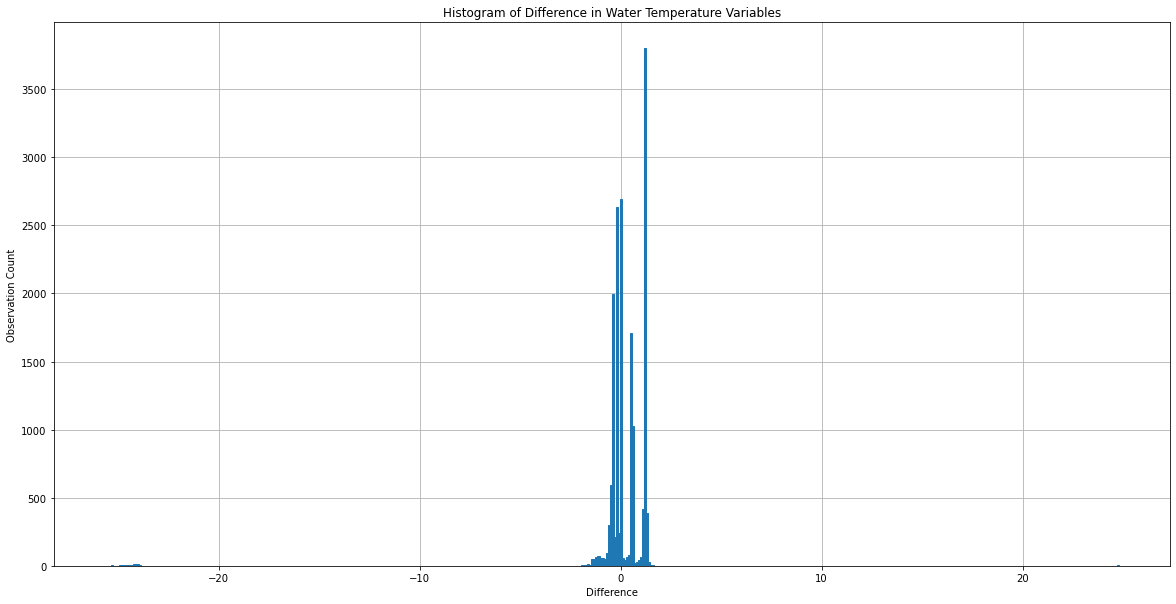

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))

water_temperature_diff.hist(bins=500, histtype='step', fill= True)

plt.title('Histogram of Difference in Water Temperature Variables')
plt.xlabel('Difference')
plt.ylabel('Observation Count')

plt.show()

In [ ]:
NOAA_full_dat[['water_temperature (degrees Celsius)',
               'water_temperature_c6 (degrees Celsius)',
               'water_temp_c6 (degrees Celsius)',
               'ctd temperature (°c)',
               'sample temperature (°c)']].describe()

The variables `water_temp_c6 (degrees Celsius)`, `ctd temperature (°c)` and `sample temperature (°c)` are likely taken from warmer months given its range, median value and smaller standard deviation compared to the other two water temperature variables.

We need to check if the different water temperature columns are mutually exclusive ie. if there is only one populated water temperature column per row. 

In [ ]:
print(NOAA_full_dat.loc[NOAA_full_dat['water_temperature (degrees Celsius)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['water_temperature_c6 (degrees Celsius)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['water_temp_c6 (degrees Celsius)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['ctd temperature (°c)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['sample temperature (°c)'].notnull(), 'station'].unique())

In [ ]:
NOAA_full_dat[(NOAA_full_dat['ctd temperature (°c)'].notnull()) & (NOAA_full_dat['sample temperature (°c)'].notnull())]

The variables `water_temperature_c6 (degrees Celsius)` and `water_temp_c6 (degrees Celsius)` are mutually exclusive. However, `water_temperature (degrees Celsius)` overlaps with these two variables each. 

The variables `sample temperature (°c)` and `ctd temperature (°c)` are specific to the small boat datasets. The former is for small boat observations from 2012 while the latter is for small boat observations from 2013 to 2019.

In [ ]:
# combine temperature columns
# NOAA_full_dat['water_temp_celsius_combined'] = NOAA_full_dat['water_temperature (degrees Celsius)'].combine_first(NOAA_full_dat['water_temperature_c6 (degrees Celsius)'])


There are 54 observations for the variable `sample temperature (°c)`. These rows are from the Small_boat_2012_2018 data set.

In [ ]:
NOAA_full_dat.loc[(NOAA_full_dat['water_temperature (degrees Celsius)'].notnull())&(NOAA_full_dat['water_temperature_c6 (degrees Celsius)'].notnull())]

### Depth

There are five variables related to depth:
- `depth_c6 (meter)`
- `depth_c6 (meters)`
- `sample depth (m)`
- `depth (meters)`
- `sample depth (category)`

In [ ]:
NOAA_full_dat[['depth_c6 (meter)', 'depth_c6 (meters)', 'sample depth (m)', 'depth (meters)', 'sample depth (category)']].describe()

In [ ]:
# check for which stations each variable is populated for
print('depth_c6 (meter):', NOAA_full_dat.loc[NOAA_full_dat['depth_c6 (meter)'].notnull() == True, 'station'].unique())
print('----------')
print('depth_c6 (meters):', NOAA_full_dat.loc[NOAA_full_dat['depth_c6 (meter)'].notnull() == True, 'station'].unique())
print('----------')
print('sample depth (m):', NOAA_full_dat.loc[NOAA_full_dat['depth_c6 (meter)'].notnull() == True, 'station'].unique())
print('----------')
print('depth (meters):', NOAA_full_dat.loc[NOAA_full_dat['depth (meters)'].notnull() == True, 'station'].unique())

### Secchi Depth

There are some non-numeric values in the `secchi depth (m)` column. We will double check what these rows contain. 

In [ ]:
nonnull_secchi = NOAA_full_dat['secchi depth (m)'][NOAA_full_dat['secchi depth (m)'].notnull()]
print('Number of non-null secchi observations:', nonnull_secchi.shape[0])
print('Number of non-null secchi observations with non-numeric characters:', nonnull_secchi.str.replace(pat = '.', repl = '', regex = False).str.isdigit().sum())

In [ ]:
NOAA_full_dat['secchi depth (m)'].loc[NOAA_full_dat['secchi depth (m)'].str.replace(pat = '.', repl = '', regex = False).str.isdigit() == False]

There are only two rows out of 978 non-null rows in `secchi depth (m)` that are strings (non-numeric). Hence, we will coerce the non-numeric rows into `NaN`. 

In [21]:
# Cast secchi depth (m) to numeric
NOAA_full_dat['secchi depth (m)'] = pd.to_numeric(NOAA_full_dat['secchi depth (m)'], errors = 'coerce')

### Date 

There are three variables related to date: `date`, `timestamp (UTC)` and `local time (eastern time zone)`. The first variable is of %-m/%d/%Y format, the second is of %-m/%d/%Y %H %M format, and the last variable is of %H %M format (24-hour notation time). The variables `date` and `local time (eastern time zone)` are in tandem, found in the small boat data sets. 

*Not sure if granularity of time is necessary, but keep it for now. Note that small boat data sets are in EST whereas timestamp (UTC) is in UTC time zone!* 

In [ ]:
# Convert dates and times from string to date object
NOAA_full_dat['date'] = pd.to_datetime(NOAA_full_dat['date'])

## May need to break down further to year, month, day, time

In [ ]:
print(NOAA_full_dat.loc[NOAA_full_dat['timestamp (UTC)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['date'].notnull(), 'station'].unique())

In [ ]:
NOAA_full_dat['timestamp (UTC)'][NOAA_full_dat['timestamp (UTC)'].notnull()].head()

In [ ]:
NOAA_full_dat['date'][NOAA_full_dat['date'].notnull()].head()

In [ ]:
# tstmo, tstday, tstyr, tsttime = re.split('[/ \\s]', NOAA_full_dat['timestamp (UTC)'][0])

# Check range of months in timestamp (UTC) variables
timestamp_notnull = NOAA_full_dat.loc[NOAA_full_dat['timestamp (UTC)'].notnull(), 'timestamp (UTC)']
timestamp_notnull.str.split(pat = '[/ \\s]').map(lambda x: x[0]).unique()

Unavailable dates in the `timestamp (UTC)` variable are coded as `NA-99-99 99:99:99`. As well, there are 5 rows with the date `2000-00-00 00:00:00` and 3 rows with `#VALUE!` randomly scattered throughout the `timestamp (UTC)` series. These must be cleaned up. 

Looking at these rows, the majority of the other variables are also NaN values, so these observations are virtually useless. I set the value of `timestamp (UTC)` to NaN for the rows with the values `NA-99-99 99:99:99`, `2000-00-00 00:00:00`and `#VALUE!` to standardize NA entries.

In [ ]:
NOAA_full_dat.iloc[timestamp_notnull[timestamp_notnull.str.startswith(
    ('NA-99-99 99:99:99', '2000-00-00 00:00:00', '#VALUE!'))].index, ]

In [ ]:
# Set rows for which timestamp (UTC) = NA-99-99 99:99:99 to NaN
NOAA_full_dat.loc[NOAA_full_dat['timestamp (UTC)'].isin([
    'NA-99-99 99:99:99', '2000-00-00 00:00:00', '#VALUE!']), 'timestamp (UTC)'] = float('NaN')

In [ ]:
# Convert timestamp (UTC) variable to pandas time 
NOAA_full_dat['timestamp (UTC)'] = pd.to_datetime(NOAA_full_dat['timestamp (UTC)'])

In [ ]:
# Would it be helpful to have speicific columns for year, month, day? Would be easier for processing 

### Phosphorus

Phosphorus is an important variable to look at as it is a limiting factor to algae bloom growth (***cite here!!***).

There are four variables related to phosphorus:
- `phosphate (micrograms per liter)`
- `total phosphorus (µg p/l)`
- `total dissolved phosphorus (µg p/l)`
- `soluble reactive phosphorus (µg p/l)`

In [ ]:
print(NOAA_full_dat.loc[NOAA_full_dat['phosphate (micrograms per liter)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['total phosphorus (µg p/l)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['total dissolved phosphorus (µg p/l)'].notnull(), 'station'].unique())
print('----------')
print(NOAA_full_dat.loc[NOAA_full_dat['soluble reactive phosphorus (µg p/l)'].notnull(), 'station'].unique())

The phosphate variable, `phosphate (micrograms per liter)`, is found in the 'WE__' data sets whereas the phosphorus variables are found in the small boat data sets. 

In [ ]:
NOAA_full_dat['phosphate (micrograms per liter)'].notnull()

In [ ]:
# get details on phosphorus variables
NOAA_full_dat[['phosphate (micrograms per liter)',
              'total phosphorus (µg p/l)',
              'total dissolved phosphorus (µg p/l)',
              'soluble reactive phosphorus (µg p/l)']].describe()

In [ ]:
print('There are', sum(NOAA_full_dat['phosphate (micrograms per liter)'] < 0), 'negative phosphate observations out of', sum(NOAA_full_dat['phosphate (micrograms per liter)'].notnull()), 'observations in total.')
NOAA_full_dat.loc[NOAA_full_dat['phosphate (micrograms per liter)'] < 0, 'phosphate (micrograms per liter)'].describe()

Not sure how to interpret negative phosphate observations!? There are also a lot of negative observations... more than 25% of the total phosphate observations. This [thread](https://www.researchgate.net/post/How_can_I_explain_negative_value_of_water_quality_parameters_nutrients_like_Nitrite_Nitrate_Phosphate) on ResearchGate suggests that this is a measurement error. For EDA, I will ignore negative values.

In [ ]:
print('total phosphorus (µg p/l):', sum(NOAA_full_dat['total phosphorus (µg p/l)'].notnull()))
print('----------')
print('total dissolved phosphorus (µg p/l):', sum(NOAA_full_dat['total dissolved phosphorus (µg p/l)'].notnull()))
print('----------')
print('soluble reactive phosphorus (µg p/l):', sum(NOAA_full_dat['soluble reactive phosphorus (µg p/l)'].notnull()))

In [ ]:
NOAA_full_dat[NOAA_full_dat['total phosphorus (µg p/l)'].notnull() &
              NOAA_full_dat['total dissolved phosphorus (µg p/l)'].notnull() &
              NOAA_full_dat['soluble reactive phosphorus (µg p/l)'].notnull()].shape

All three phosphorus observations have non-null values for 1002 rows. There are a few rows where there are at least one of these variables are null. 

In [ ]:
phos_rows = NOAA_full_dat[['total phosphorus (µg p/l)', 'total dissolved phosphorus (µg p/l)', 'soluble reactive phosphorus (µg p/l)']].dropna(thresh = 1)

In [ ]:
NOAA_full_dat.iloc[list(set(list(phos_rows[phos_rows['total phosphorus (µg p/l)'].isnull()].index) + list(phos_rows[phos_rows['total dissolved phosphorus (µg p/l)'].isnull()].index) + list(phos_rows[phos_rows['soluble reactive phosphorus (µg p/l)'].isnull()].index)))]

In [ ]:
NOAA_full_dat.iloc[list(set(list(phos_rows[phos_rows['total phosphorus (µg p/l)'].isnull()].index) + list(phos_rows[phos_rows['total dissolved phosphorus (µg p/l)'].isnull()].index) + list(phos_rows[phos_rows['soluble reactive phosphorus (µg p/l)'].isnull()].index)))].shape

### Dissolved Oxygen

There are three variables related to dissolved oxygen:
- `organic_dissolved_oxygen_saturation (%)`
- `organic_dissolved_oxygen (milligrams per liter)`
- `ctd dissolved oxygen (mg/l)`

In [ ]:
[var for var in NOAA_full_dat.columns if 'oxy' in var]

In [ ]:
print('organic_dissolved_oxygen_saturation (%):', NOAA_full_dat.loc[NOAA_full_dat['organic_dissolved_oxygen_saturation (%)'].notnull(), 'station'].unique())
print('----------')
print('organic_dissolved_oxygen (milligrams per liter):', NOAA_full_dat.loc[NOAA_full_dat['organic_dissolved_oxygen (milligrams per liter)'].notnull(), 'station'].unique())
print('----------')
print('ctd dissolved oxygen (mg/l):', NOAA_full_dat.loc[NOAA_full_dat['ctd dissolved oxygen (mg/l)'].notnull(), 'station'].unique())

In [ ]:
# get details on dissolved oxygen variables
# NOTE THAT ctd dissolved oxygen is grouped! It's only part of the small boat sets

NOAA_full_dat[['organic_dissolved_oxygen_saturation (%)',
               'organic_dissolved_oxygen (milligrams per liter)',
               'ctd dissolved oxygen (mg/l)']].describe()

In [ ]:
print('Number of rows in which organic dissolved oxygen saturation (%) and (milligrams per liter) are not null:', 
      NOAA_full_dat.loc[NOAA_full_dat['organic_dissolved_oxygen (milligrams per liter)'].notnull() &
                        NOAA_full_dat['organic_dissolved_oxygen_saturation (%)'].notnull()].shape[0])

The variables `organic_dissolved_oxygen_saturation (%)` and `organic_dissolved_oxygen (milligrams per liter)` are observations from the WE__ data sets and non-null for the same rows. Since these variables represent the same attribute, I will choose one for organic dissolved oxygen. For the sake of uniformity, I will select the milligram per liter version.

### pH

There are three variables related to pH:
- `ph`
- `ph_mv (millivolts)`
- `ph (pH)`

In [ ]:
print('ph:', NOAA_full_dat.loc[NOAA_full_dat['ph'].notnull(), 'station'].unique())
print('----------')
print('ph_mv (millivolts):', NOAA_full_dat.loc[NOAA_full_dat['ph_mv (millivolts)'].notnull(), 'station'].unique())
print('----------')
print('ph (pH):', NOAA_full_dat.loc[NOAA_full_dat['ph (pH)'].notnull(), 'station'].unique())

NOAA_full_dat[['ph',
               'ph_mv (millivolts)',
               'ph (pH)']].describe()

All three pH variables are from the WE__ data sets. It seems that `ph` and `ph (pH)` are names referring to the same measurement and so should be merged into one column. Looking at the original individual data sets in the `NOAA_sets` dictionary, 'pH' appears as a measurement unit in WE__ data sets from 2015 onwards. We look at `ph_mv (millivolts)` in more detail. 

In [ ]:
# NOAA_full_dat['ph_mv (millivolts)'].astype(float) 

np.setdiff1d(NOAA_full_dat[NOAA_full_dat['ph_mv (millivolts)'].notnull()].index.tolist(),
             NOAA_full_dat[NOAA_full_dat['ph_mv (millivolts)'].str.contains('\s') == True].index.tolist())

NOAA_full_dat[1:3522]['station'].unique()
# flag issue again for this!! Could ignore since we can using pH anyway... 

I will check for which stations and time periods that `ph_mv (millivolts)` are flag values.

In [ ]:
ph_mv_check = NOAA_full_dat.loc[NOAA_full_dat['ph_mv (millivolts)'].str.contains('\s') == True, ['station', 'timestamp (UTC)', 'ph_mv (millivolts)']]
ph_mv_check['timestamp year'] = ph_mv_check['timestamp (UTC)'].dt.year 
print('ph_mv flag values are found in years:', ph_mv_check['timestamp year'].unique())
print('ph_mv flag values are found in stations:', ph_mv_check['station'].unique())

Could the pH flags be missing in the 2015 sets of WE04, WE08 and WE13?

In [ ]:
print(NOAA_full_dat.loc[NOAA_full_dat['ph_flags'].notnull(), 'timestamp (UTC)'].dt.year.unique())
print(NOAA_full_dat.loc[NOAA_full_dat['ph_flags'].notnull(), 'station'].unique())

ph_flag_check = NOAA_full_dat.loc[NOAA_full_dat['ph_flags'].notnull()]
ph_flag_check['timestamp year'] = NOAA_full_dat['timestamp (UTC)'].dt.year

ph_flag_check.groupby(['timestamp year','station']).size()

In [ ]:
print(NOAA_full_dat.loc[NOAA_full_dat['ph_mv (millivolts)'].notnull(), 'timestamp (UTC)'].dt.year.unique())
print(NOAA_full_dat.loc[NOAA_full_dat['ph_mv (millivolts)'].notnull(), 'station'].unique())

ph_mv_flag_check = NOAA_full_dat.loc[NOAA_full_dat['ph_mv (millivolts)'].notnull()]
ph_mv_flag_check['timestamp year'] = NOAA_full_dat['timestamp (UTC)'].dt.year

ph_mv_flag_check.groupby(['timestamp year','station']).size()

In [ ]:
NOAA_sets['WE02_2014_annual_summary']['ph_mv (millivolts)'].describe()

In [ ]:
print('Number of non-null rows, WE02 2014:', 
      NOAA_sets['WE02_2014_annual_summary'][NOAA_sets['WE02_2014_annual_summary']['ph_mv (millivolts)'].notnull()].shape[0])
print(NOAA_sets['WE02_2014_annual_summary']['ph_mv (millivolts)'].astype(float))

print('---------------')

print('Number of non-null rows, WE04 2015:', 
      NOAA_sets['WE04_2015_annual_summary'][NOAA_sets['WE04_2015_annual_summary']['ph_mv (millivolts)'].notnull()].shape[0])
print(NOAA_sets['WE04_2015_annual_summary']['ph_mv (millivolts)'].str.contains('\s').sum())

print('---------------')

print('Number of non-null rows, WE08 2015:', 
      NOAA_sets['WE08_2015_annual_summary'][NOAA_sets['WE08_2015_annual_summary']['ph_mv (millivolts)'].notnull()].shape[0])
print(NOAA_sets['WE08_2015_annual_summary']['ph_mv (millivolts)'].str.contains('\s').sum())

print('---------------')

print('Number of non-null rows, WE13 2015:', 
      NOAA_sets['WE13_2015_annual_summary'][NOAA_sets['WE13_2015_annual_summary']['ph_mv (millivolts)'].notnull()].shape[0])
print(NOAA_sets['WE13_2015_annual_summary']['ph_mv (millivolts)'].str.contains('\s').sum())

In the 2015 sets for WE04, WE08 and WE13 stations, `ph_mv (millivolts)` contains flag values. Since there is another variable for pH and because only less than 10% of the observations in the merged data set have non-null values for `ph_mv (millivolts)`, I will not use `ph_mv (millivolts)` but use `ph` and `ph (pH)` instead. 

The `describe` summary for `ph` and show that its mean value is -2.243070 and that its minimum value is -411.275000. This is strange as a pH reading that negative would mean there is a much larger issue than algae blooms in the lake. We will explore the negative readings for `ph` next. 

In [ ]:
NOAA_sets['WE02_2015_annual_summary']['ph (pH)'].describe()

# there are some particularly low pH readings, check the ecdf of ph (PH)
NOAA_sets['WE02_2015_annual_summary']['ph (pH)'].quantile(0.01)

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

In [ ]:
print(NOAA_full_dat['ph (pH)'].quantile(0.0201))

print(np.where(ECDF(NOAA_full_dat['ph (pH)']).x < 2)[0].max())
print(np.where(ECDF(NOAA_full_dat['ph (pH)']).x < 5)[0].max())
print(np.where(ECDF(NOAA_full_dat['ph (pH)']).x < 7)[0].max())

print('Percentile of ph (pH) observations less than 7:', 
      sum(NOAA_full_dat['ph (pH)'] < 7)/sum(NOAA_full_dat['ph (pH)'].notnull())) 

In [ ]:
print(NOAA_full_dat['ph'].quantile(0.0201))

print(np.where(ECDF(NOAA_full_dat['ph']).x < 2)[0].max())
print(np.where(ECDF(NOAA_full_dat['ph']).x < 5)[0].max())
print(np.where(ECDF(NOAA_full_dat['ph']).x < 7)[0].max())

print('Proportion of ph observations less than 7:', 
      sum(NOAA_full_dat['ph'] < 7)/sum(NOAA_full_dat['ph'].notnull()))

In [ ]:
print(sum(NOAA_full_dat['ph'] < 0)/sum(NOAA_full_dat['ph'].notnull()))

print(sum(NOAA_full_dat['ph (pH)'] < 0)/sum(NOAA_full_dat['ph (pH)'].notnull()))

In [ ]:
print('Years with negative ph observations:', NOAA_full_dat.loc[(NOAA_full_dat['ph'].notnull()) & (NOAA_full_dat['ph'] < 0), 
                                                               'timestamp (UTC)'].dt.year.unique())
print('Stations with negative ph observations:', NOAA_full_dat.loc[(NOAA_full_dat['ph'].notnull()) & (NOAA_full_dat['ph'] < 0), 
                                                               'station'].unique())

In [ ]:
print('Summary of 2014 WE02 ph negative observations:\n{}\n'.format(
    NOAA_sets['WE02_2014_annual_summary'].loc[(NOAA_sets['WE02_2014_annual_summary']['ph'] < 0), 'ph'].describe()))
print('Summary of 2014 WE02 ph non-negative observations:\n{}'.format(
    NOAA_sets['WE02_2014_annual_summary'].loc[(NOAA_sets['WE02_2014_annual_summary']['ph'] >= 0), 'ph'].describe()))

In [ ]:
sum(NOAA_sets['WE02_2014_annual_summary']['ph'].between(6, 7.5, inclusive = True))

It seems like there is a large chasm between the negative and the non-negative values for `ph` in the 2014 WE02 data set. It is likely that the negative values are not on the pH scale but measurements in millivolts instead! To deal with the negative values, I could set these observations as `NaN` or can create a flag for the negative values. Regardless, the `ph` and `ph (pH)` columns should be merged into one. 

In [ ]:
ph_check = NOAA_full_dat.loc[NOAA_full_dat['ph'].notnull()]
ph_check['timestamp year'] = NOAA_full_dat['timestamp (UTC)'].dt.year

ph_check.groupby(['timestamp year','station']).size()

In [ ]:
ph_units_check = NOAA_full_dat.loc[NOAA_full_dat['ph (pH)'].notnull()]
ph_units_check.loc[:,'timestamp year'] = NOAA_full_dat['timestamp (UTC)'].dt.year

ph_units_check.groupby(['timestamp year','station']).size()

In [ ]:
# CREATED ph (ph scale) VARIABLE THAT IS COMBINATION OF ph and ph (pH)

# First initialize new ph variable using ph as it's more complete and 
# doesn't have issues with negative pH values
NOAA_full_dat.loc[:, 'ph (ph scale)'] = NOAA_full_dat['ph (pH)']

# Double check if ph (pH) and ph are mutually exclusive in a given row
sum(NOAA_full_dat['ph (pH)'].notnull() & NOAA_full_dat['ph'].notnull())

# Include all ph values in the ph (pH) column
NOAA_full_dat['ph (ph scale)'].where(
    NOAA_full_dat['ph (ph scale)'].notnull(), other = NOAA_full_dat['ph'], inplace = True)

# Set negative pH values as NaN in new column ph (ph scale)
NOAA_full_dat['ph (ph scale)'].where(
    NOAA_full_dat['ph (ph scale)'] >= 0, other = float('NaN'), inplace = True)

In [ ]:
NOAA_full_dat['ph (ph scale)'].describe()
print('There are {} pH observations that are greater than 7.'.format(
    sum(NOAA_full_dat['ph (ph scale)'] > 7)))

### Chlorophyll a

There are five variables related to chlorophyll a:
- `chlorophylla_rfu (RFU)`
- `chlorophylla (micrograms per liter)`
- `chlorophylla_c6 (RFU)`
- `chlorophylla (RFU)`
- `extracted chlorophyll a (µg/l)`

In [ ]:
print('chlorophylla_rfu (RFU):', NOAA_full_dat.loc[NOAA_full_dat['chlorophylla_rfu (RFU)'].notnull(), 'station'].unique())
print('----------')
print('chlorophylla (micrograms per liter):', NOAA_full_dat.loc[NOAA_full_dat['chlorophylla (micrograms per liter)'].notnull(), 'station'].unique())
print('----------')
print('chlorophylla_c6 (RFU):', NOAA_full_dat.loc[NOAA_full_dat['chlorophylla_c6 (RFU)'].notnull(), 'station'].unique())
print('----------')
print('chlorophylla (RFU):', NOAA_full_dat.loc[NOAA_full_dat['chlorophylla (RFU)'].notnull(), 'station'].unique())
print('----------')
print('extracted chlorophyll a (µg/l):', NOAA_full_dat.loc[NOAA_full_dat['extracted chlorophyll a (µg/l)'].notnull(), 'station'].unique())

In [ ]:
NOAA_full_dat[NOAA_full_dat['chlorophylla_rfu (RFU)'].notnull() &
              NOAA_full_dat['chlorophylla (micrograms per liter)']].shape

In [ ]:
# get details on chlorophyll a variables
NOAA_full_dat[['chlorophylla_rfu (RFU)',
               'chlorophylla (micrograms per liter)',
               'chlorophylla_c6 (RFU)',
               'chlorophylla (RFU)',
               'extracted chlorophyll a (µg/l)']].describe()

In [ ]:
NOAA_full_dat.loc[NOAA_full_dat['chlorophylla_rfu (RFU)'].notnull() &
              NOAA_full_dat['chlorophylla (micrograms per liter)'].notnull(),
             'station']

In [ ]:
NOAA_full_dat[NOAA_full_dat['station'] == 'WE02'].shape

The variables `chlorophylla_rfu (RFU)` and `chlorophylla (micrograms per liter)` are from the same data set, WE02. Strangely enough, WE02 has all four variables that are part of the WE__ data sets! The variable `extracted chlorophyll a (µg/l)` is from the small boats data sets.

There are negative values in the `chlorophylla (RFU)` data set, which is concerning considering that RFU should not have negative values.

In [ ]:
NOAA_full_dat.shape

Note RFU = relative fluorescence units. C6 refers to a sampling instrument - Turner C6.

**Note: according to the [US Geological Survey](https://waterwatch.usgs.gov/wqwatch/faq?faq_id=5), "large daily variations in sensor measurements that are not related to chlorophyll concentrations may occur due to changing light and temperature conditions, which affect the fluorescence response of algal cells."** Should we use phycocyanin ($\mu$g/l) as a proxy for chlorophyll concentration then?

## Exploratory Data Analysis

First, we will explore the univariate relationship between the target variable chlorophyll a and key covariates in the NOAA data sets: water temperature, dissolved oxygen, pH and phosphorus. 

Phycocyanin is a pigment-protein found in cyanobacteria according to [Science Direct](https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/phycocyanin). Can phycocyanin be seen as a derivative of the response chlorophyll?

2020/10/18: for grouping of variables (ex. water temperature, chlorophyll a), the variable with the majority of observations are included in EDA. 

### Geographic Location of Stations

In [ ]:
import OSMPythonTools as osm
# from mpl_toolkits.basemap import Basemap
# _geoslib module missing for the mpl_toolkits.basemap import

# Cite when you use cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
print('Range of latitude degrees: {}, {}'.format(
    min(NOAA_full_dat['latitude (decimal deg)']),
    max(NOAA_full_dat['latitude (decimal deg)']))
     )

print('Range of longitude degrees: {}, {}'.format(
    min(NOAA_full_dat['longitude (decimal deg)']),
    max(NOAA_full_dat['longitude (decimal deg)']))
     )

In [ ]:
NOAA_coords_copy = NOAA_coords

for k in NOAA_coords_copy.keys():
    NOAA_coords_copy[k].rename(columns = {0: 'lon', 1: 'lat'}, inplace = True)
    NOAA_coords_copy[k].loc[:,'station'] = k
    
station_coords = pd.concat(NOAA_coords_copy.values())

In [ ]:
boat_unique_coords = NOAA_full_dat.loc[
    NOAA_full_dat['station'].str.contains('boat'), 
    ['station', 'latitude (decimal deg)', 'longitude (decimal deg)']].groupby(
    ['station', 'latitude (decimal deg)', 'longitude (decimal deg)'], as_index = False
).size()

In [ ]:
station_coords

In [ ]:
print(boat_unique_coords['size'].value_counts())
# compare with 1463, the number of rows in small boat sets

print('\n')
print('Number of non-null longitude values:', 
      NOAA_full_dat.loc[NOAA_full_dat['station'].str.contains('boat'), 
                        'longitude (decimal deg)'].notnull().sum())

print('Number of non-null latitude values:', 
      NOAA_full_dat.loc[NOAA_full_dat['station'].str.contains('boat'), 
                        'latitude (decimal deg)'].notnull().sum())

In [ ]:
fig = plt.figure(figsize=(20, 10))

# set up map
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

# define map boundaries by lon, lat
ax.set_extent([min(NOAA_full_dat['longitude (decimal deg)']) - 0.2,
               max(NOAA_full_dat['longitude (decimal deg)']) + 0.2, 
               max(NOAA_full_dat['latitude (decimal deg)']) + 0.2, 
               min(NOAA_full_dat['latitude (decimal deg)']) - 0.2], 
              crs = ccrs.PlateCarree()
             )

# add features to the map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.75)
ax.add_feature(cfeature.RIVERS)

# overlay map image
ax.stock_img()

# plot points for boat observations
ax.plot(boat_unique_coords['longitude (decimal deg)'].to_numpy().tolist(), 
        boat_unique_coords['latitude (decimal deg)'].to_numpy().tolist(),
        color='mediumslateblue', marker='.', ls='',
        transform=ccrs.Geodetic(),
        )

# add points for the stations!
ax.plot(station_coords['lon'].to_numpy().tolist(), 
        station_coords['lat'].to_numpy().tolist(),
        color='red', marker='o', ls='',
        transform=ccrs.Geodetic(),
        )

# include text for station names
for i in range(0, station_coords.shape[0]): 
    ax.text(station_coords.iloc[i,]['lon'], 
            station_coords.iloc[i,]['lat'] + 0.02,
            s = station_coords.iloc[i,]['station'],
            ha = 'center',
            transform=ccrs.Geodetic()
           )

plt.show()

There appears to be some observations that are outside of the lake? Will have to double check, starting with the westernmost and southernmost observations. **Note: rivers don't appear on large scale maps!**

In [ ]:
boat_unique_coords.iloc[
    boat_unique_coords['longitude (decimal deg)'].nsmallest(keep = 'all').index]

boat_unique_coords.iloc[
    boat_unique_coords['latitude (decimal deg)'].nsmallest(keep = 'all').index]

In [ ]:
NOAA_full_dat.iloc[
    NOAA_full_dat['latitude (decimal deg)'].nsmallest(keep = 'all').index
]

On Google Maps, these coordinates seem to be on land. 

In [ ]:
import pip
from pip._internal.utils.misc import get_installed_distributions
# [lib for lib in get_installed_distributions() if 'map' in lib]

get_installed_distributions()

### Water Temperature

In [ ]:
print('There are {} observation pairs for water temperature (degrees Celsius) and chlorophyll a (RFU).'.format(
 sum(NOAA_full_dat['water_temperature (degrees Celsius)'].notnull() & NOAA_full_dat['water_temperature (degrees Celsius)'].notnull())))

In [ ]:
# Look at scatterplot of chlorophyll a vs water temperature 
# with colour grouping by year

fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x = NOAA_full_dat['chlorophylla (RFU)'], 
                y = NOAA_full_dat['water_temperature (degrees Celsius)'], 
                hue = NOAA_full_dat['timestamp (UTC)'].dt.year, 
                legend = 'full',
                palette = 'rainbow', 
                alpha = 0.3).legend().set_title('Year')

# plt.legend(title='Timestamp - Month', loc='lower right')
# chlor_wat_temp_plot._legend.set_title('Timestamp Month')

plt.title('Scatterplot of Chlorophyll a vs Water Temperature')
plt.xlabel('Chlorophyll a (RFU)')
plt.ylabel('Water Temperature (Degree Celsius)')
plt.show()

The majority of observations across the range of water temperature have `chlorophylla (RFU)` less than 20 RFU. The year 2014 has particularly high chlorophyll a measurements. 2018 also seems to have more observations with water temperatures in the 15 to 30 degrees Celsius range; this may be an issue with the data in that there are fewer `NaN` values for the variables `chlorophylla (RFU)` and `water_temperature (degrees Celsius)` in 2018. There seems to be more cooler observations in 2016.

In [ ]:
# Look at scatterplot of chlorophyll a vs water temperature 
# with colour grouping by station

fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x = NOAA_full_dat['chlorophylla (RFU)'], 
                y = NOAA_full_dat['water_temperature (degrees Celsius)'], 
                hue = NOAA_full_dat['station'], 
                legend = 'full',
                palette = sns.color_palette('hls', len(NOAA_full_dat['station'].unique())), 
                alpha = 0.3)

plt.title('Scatterplot of Chlorophyll a vs Water Temperature')
plt.xlabel('Chlorophyll a (RFU)')
plt.ylabel('Water Temperature (Degree Celsius)')
plt.show()

Most of the observations with high chlorophyll a readings are from station WE08. 

### Dissolved Oxygen

Used `organic_dissolved_oxygen (milligrams per liter)` for the EDA. 

In [ ]:
print('There are {} observation pairs for organic dissolved oxygen (milligrams per liter) and chlorophyll a (RFU).'.format(
 sum(NOAA_full_dat['water_temperature (degrees Celsius)'].notnull() & NOAA_full_dat['organic_dissolved_oxygen (milligrams per liter)'].notnull())))

[var for var in NOAA_full_dat.columns if 'oxy' in var]

In [ ]:
NOAA_full_dat.loc[NOAA_full_dat['timestamp (UTC)'].dt.year == 2018.0,'organic_dissolved_oxygen (milligrams per liter)'].describe()

In [ ]:
# Look at scatterplot of chlorophyll a vs dissolved oxygen concentration 
# with colour grouping by year

fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x = NOAA_full_dat['chlorophylla (RFU)'], 
                y = NOAA_full_dat['organic_dissolved_oxygen (milligrams per liter)'], 
                hue = NOAA_full_dat['timestamp (UTC)'].dt.year, 
                legend = 'full',
                palette = 'rainbow', 
                alpha = 0.3).legend().set_title('Year')

plt.title('Scatterplot of Chlorophyll a vs Organic Dissolved Oxygen')
plt.xlabel('Chlorophyll a (RFU)')
plt.ylabel('Organic Dissolved Oxygen (milligrams/liter)')
plt.show()

Low dissolved oxygen is usually a consequence of algal growth! From [Science Daily](https://www.sciencedaily.com/terms/algal_bloom.htm): 

>"Some algal blooms are the result of an excess of nutrients (particularly phosphorus and nitrogen) into waters and higher concentrations of these nutrients in water cause increased growth of algae and green plants.   
As more algae and plants grow, others die.   
This dead organic matter becomes food for bacteria that decompose it.  
With more food available, the bacteria increase in number and use up the dissolved oxygen in the water."

Interesting that observations with the highest chlorophyll a readings have higher organic dissolved oxygen. Water temperature and organic dissolve oxygen concentrations are inversely related, so it may be helpful to see a scatterplot of the above but with months as the colour groupings instead of years. 

We also note there are roughly 6500 fewer observation pairs of (chlorophyll a (RFU), organic_dissolved_oxygen (milligrams per liter)) than (chlorophyll a (RFU), water_temperature (degrees Celsius)).

In [ ]:
NOAA_full_dat['timestamp (UTC)'].dt.month.describe()

In [ ]:
# Look at scatterplot of chlorophyll a vs dissolved oxygen
# with colour grouping by month

fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x = NOAA_full_dat['chlorophylla (RFU)'], 
                y = NOAA_full_dat['organic_dissolved_oxygen (milligrams per liter)'], 
                hue = NOAA_full_dat['timestamp (UTC)'].dt.month, 
                legend = 'full',
                palette = 'rainbow', 
                alpha = 0.3).legend().set_title('Month')

plt.title('Scatterplot of Chlorophyll a vs Organic Dissolved Oxygen')
plt.xlabel('Chlorophyll a (RFU)')
plt.ylabel('Organic Dissolved Oxygen (milligrams/liter)')
plt.show()

The scatterplot of chlorophyll a vs organic dissolved oxygen with colour groupings by months show that the observations with notably high chlorophyll a readings are from May. Coupling the scatterplot with colour groupings by year above and this scatterplot with colour groupings by month shows that May 2018 had particularly high chlorophyll a observations. Important to note that we cannot view this univariate relationship in a vacuum - there may have been external factors that cause readings to be so elevated!

### pH

Used `ph (pH scale)` for the EDA. 

In [ ]:
print('Summary of ph (ph scale) observations: \n{}\n'.format(
    NOAA_full_dat['ph (ph scale)'].describe()))
print('Summary of ph (ph scale) for observations with chlorophylla (RFU) > 11:\n{}\n'.format(
    NOAA_full_dat.loc[NOAA_full_dat['ph (ph scale)'] > 11, 'ph (ph scale)'].describe()))
print('Summary of ph (ph scale) for observations with chlorophylla (RFU) < 7:\n{}'.format(
    NOAA_full_dat.loc[NOAA_full_dat['ph (ph scale)'] < 7, 'ph (ph scale)'].describe()))

In [ ]:
# Look at scatterplot of chlorophyll a vs pH
# with colour grouping by year

fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x = NOAA_full_dat['chlorophylla (RFU)'], 
                y = NOAA_full_dat['ph (ph scale)'], 
                hue = NOAA_full_dat['timestamp (UTC)'].dt.year, 
                legend = 'full',
                palette = 'rainbow', 
                alpha = 0.3).legend().set_title('Year')

plt.title('Scatterplot of Chlorophyll a vs pH')
plt.xlabel('Chlorophyll a (RFU)')
plt.ylabel('pH (pH scale)')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

# plot ECDF of ph (ph scale)
NOAA_full_dat['ph (ph scale)'].hist(cumulative=True, density=1, bins=1000, histtype='step')
plt.title('ECDF of ph (ph scale)')
plt.xlabel('pH (pH scale)')
plt.ylabel('% of non-null observations')

# add lines denoting 5th, 95th percentile
plt.axhline(y=0.05, color = 'r') 
plt.axhline(y=0.95, color = 'r') 

plt.show()

print(NOAA_full_dat['ph (ph scale)'].quantile([0.05, 0.1, 0.9, 0.95]))

In [ ]:
print(NOAA_full_dat['ph (ph scale)'].quantile([0.02, 0.98]))

Observations with higher chlorophyll a readings have higher-than-median pH readings. According to the [North Carolina Environmental Quality](https://deq.nc.gov/about/divisions/water-resources/water-resources-data/water-sciences-home-page/ecosystems-branch/algal-blooms), "high pH (greater than 8.0) can be an indicator of photosynthesis by large quantities of algae" as algae photosynthesis raise hydroxide levels in the water. 90% of the non-null observations for `ph (ph scale)` lie between 7.92 and 9.35, so pH may not be a strong predictor as the majority of observations have pH within these bounds. 

### Phosphorus 

In [ ]:
NOAA_full_dat.loc[NOAA_full_dat['chlorophylla (RFU)'].notnull() &
                 NOAA_full_dat['phosphate (micrograms per liter)'].notnull()]

In [ ]:
# Remember, phosphate timestamp DO NOT align with the rest of the observations in the WE__ data sets
# because phosphate records are found in a separate file!

fig, ax = plt.subplots()

sns.scatterplot(x = NOAA_full_dat['chlorophylla (RFU)'], 
                y = NOAA_full_dat['phosphate (micrograms per liter)'], 
                hue = NOAA_full_dat['timestamp (UTC)'].dt.year, 
                legend = 'full',
                palette = 'rainbow', 
                alpha = 0.3)

plt.title('Scatterplot of Chlorophyll a vs Phosphate')
plt.xlabel('Chlorophyll a (RFU)')
plt.ylabel('Phosphate (micrograms per liter)')
plt.show()

# Basin Comparison

We compare the measurements from the Western basin and from the Eastern basin. 

# Scrap Code/Notes

Is this the device used to take measurements? https://waterwatch.usgs.gov/wqwatch/faq?faq_id=5

In [ ]:
dirList = os.listdir(noaa_dir)
print(dirList)

[os.path.isdir(path) for path in
 [os.path.join(noaa_dir, direct) for direct in dirList]]

# Check for differences and similarities in the WE04 2015 and 2016 data sets
set(NOAA_sets['WE04_2015_annual_summary'].columns).symmetric_difference(set(NOAA_sets['WE04_2016_annual_summary'].columns))
len(set(NOAA_sets['WE04_2015_annual_summary'].columns).intersection(set(NOAA_sets['WE04_2016_annual_summary'].columns)))

# Set up wrapper function for fuzzy matching 
# Inputs are vector of strings and minimum Levenshtein distance to group similar strings
def fuzz_set_ratio(strings, min_lev_ratio):
    return map(lambda ratio: ratio < min_lev_ratio, map(lambda name: fuzz.token_set_ratio(strings, name), lev_arr))

# To get variable names for which Lev ratio is greater than threshold value
[NOAA_orig_vars[i] for i in [index for index, value in enumerate(tst_lev_dist) if value > 50]]